# Predictive Maintenance Analysis  
## **Author:** *Owen Nda Diche*

## Introduction

This project explores the **AI4I Predictive Maintenance Dataset**, which contains simulated machine operating conditions and failure types. The aim is to understand the factors associated with machine failures and develop a machine-learning model capable of predicting whether a machine is likely to fail.

Predictive maintenance is an important application of data science across many industries. By anticipating failures before they occur, organisations can reduce downtime, extend equipment lifespan, and optimise maintenance schedules.

## Objectives

In this notebook, I will:

- Load and preprocess the dataset  
- Explore the structure and statistical properties of the data  
- Visualise important operational trends  
- Train a machine-learning classification model  
- Evaluate the model’s performance  
- Generate insights to support data-driven maintenance decisions  

This notebook demonstrates a full data-science workflow using Python, including data cleaning, exploratory data analysis, visualisation, and model development.


## Import Required Libraries
In this section, we import all the Python libraries needed for the analysis.  
- `pandas` and `numpy` for data manipulation  
- `matplotlib` and `seaborn` for visualisation  
- `sklearn` for machine learning models and evaluation metrics


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

##  Load the Dataset
Load the AI4I Predictive Maintenance dataset using pandas.  
The file was saved as **data.csv**, so we load it directly.


In [2]:
df = pd.read_csv("data.csv")  # If it's just "data", use "data"
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Basic Dataset Exploration
Here we look at:
- the shape of the dataset  
- column information  
- missing values  
- descriptive statistics  
This helps us understand data quality and structure before analysis.


In [3]:
df.shape

(10000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [6]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Create a Results Folder for Saving Images
This section creates a folder called `Results` in the project directory.

We also define a helper function `save_fig(filename)` which saves the current 
matplotlib figure to the Results folder.


In [12]:
results_dir = "Results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

def save_fig(filename):
    """
    Save the current matplotlib figure to the Results folder.
    """
    filepath = os.path.join(results_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved figure: {filepath}")


##  Exploratory Data Analysis (EDA)
We plot distributions and relationships between features.
This helps reveal patterns, detect outliers, and validate assumptions.


### Target Variable Distribution
Visualise how many machines failed vs did not fail.


Saved: Results\machine_failure_distribution.png


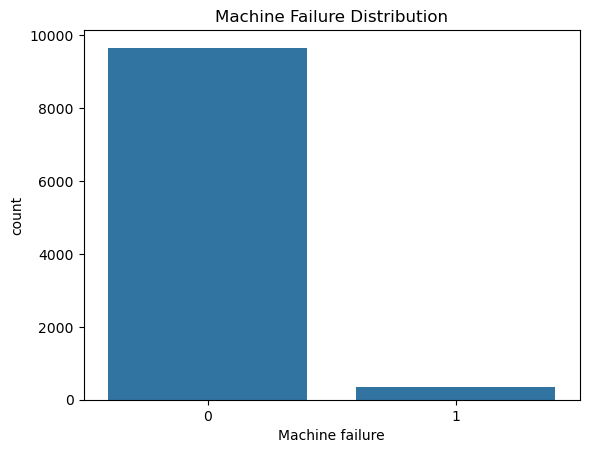

In [14]:
sns.countplot(data=df, x='Machine failure')
plt.title("Machine Failure Distribution")
save_fig("machine_failure_distribution.png")
plt.show()

### Correlation Heatmap
Shows correlation relationships between numerical variables.


Saved: Results\correlation_heatmap.png


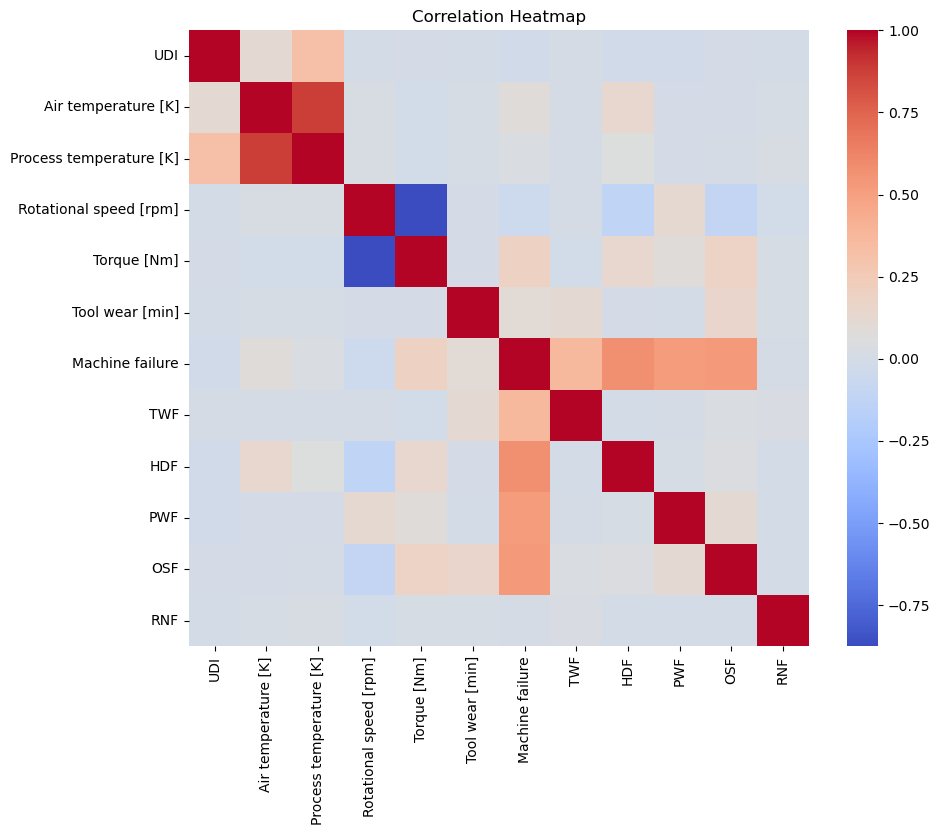

In [17]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
save_fig("correlation_heatmap.png")
plt.show()


### Numerical Feature Distributions
Visualise the distribution of key numeric features.


Saved: Results\feature_histograms.png


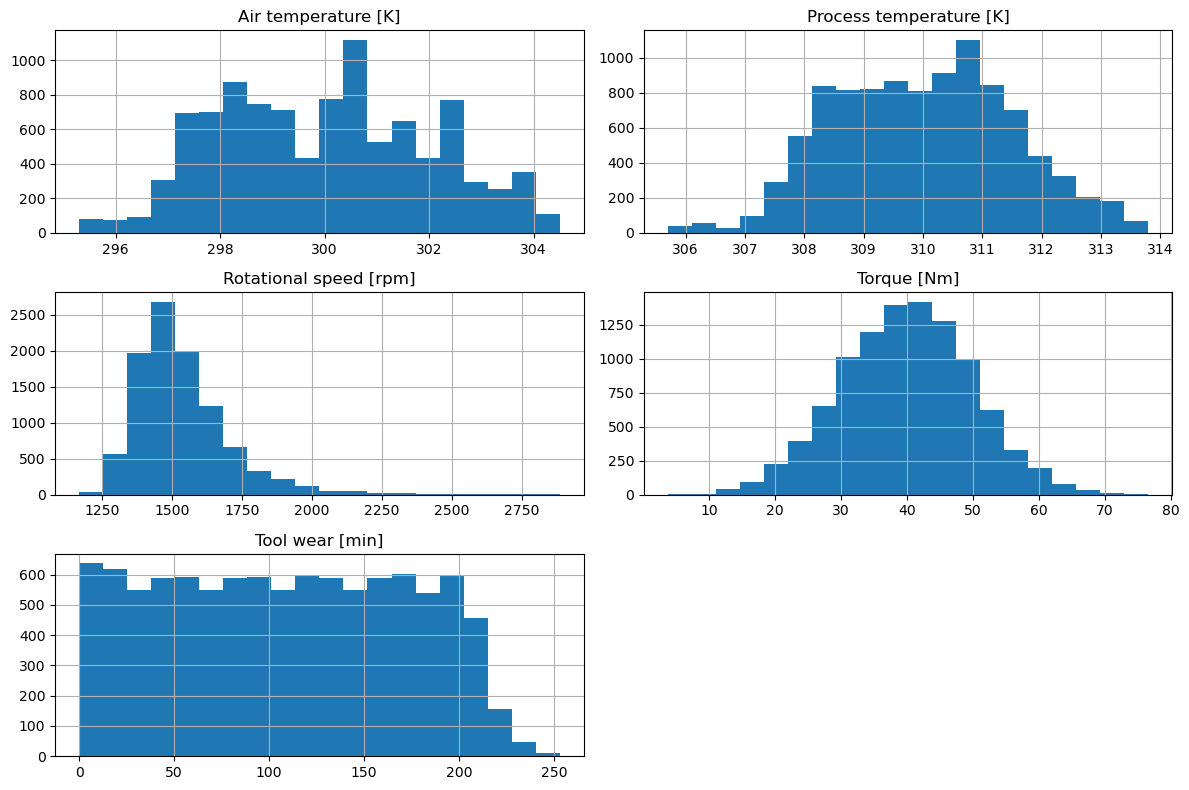

In [18]:
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

df[numeric_cols].hist(figsize=(12,8), bins=20)
plt.tight_layout()
save_fig("feature_histograms.png")
plt.show()


## Prepare Data for Machine Learning
We:
- choose features (X) and target variable (y)
- one-hot encode categorical data
- split into train/test sets
- scale numerical features


In [19]:
# Input features
X = df.drop('Machine failure', axis=1)

# Target variable
y = df['Machine failure']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train a Machine Learning Model
We use a Random Forest classifier because it performs well on structured data 
and offers feature importance insights.


In [20]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

## Model Evaluation
We evaluate the model using:
- classification report  
- confusion matrix  
- ROC-AUC score  


In [21]:
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC Score: 0.9870433466633977


### Confusion Matrix Plot

Saved: Results\confusion_matrix.png


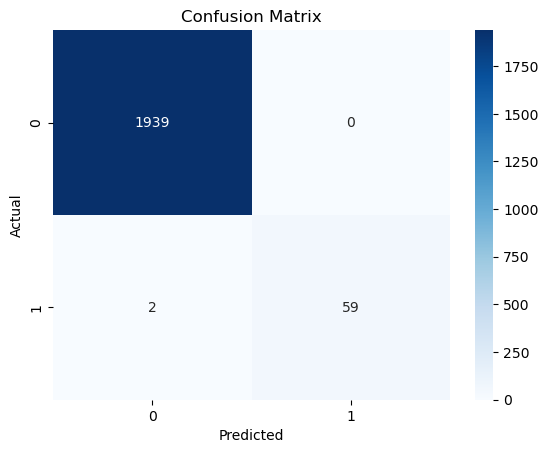

In [22]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
save_fig("confusion_matrix.png")
plt.show()


## Feature Importance
Shows which features contribute most to predicting machine failure.


Saved: Results\feature_importance.png


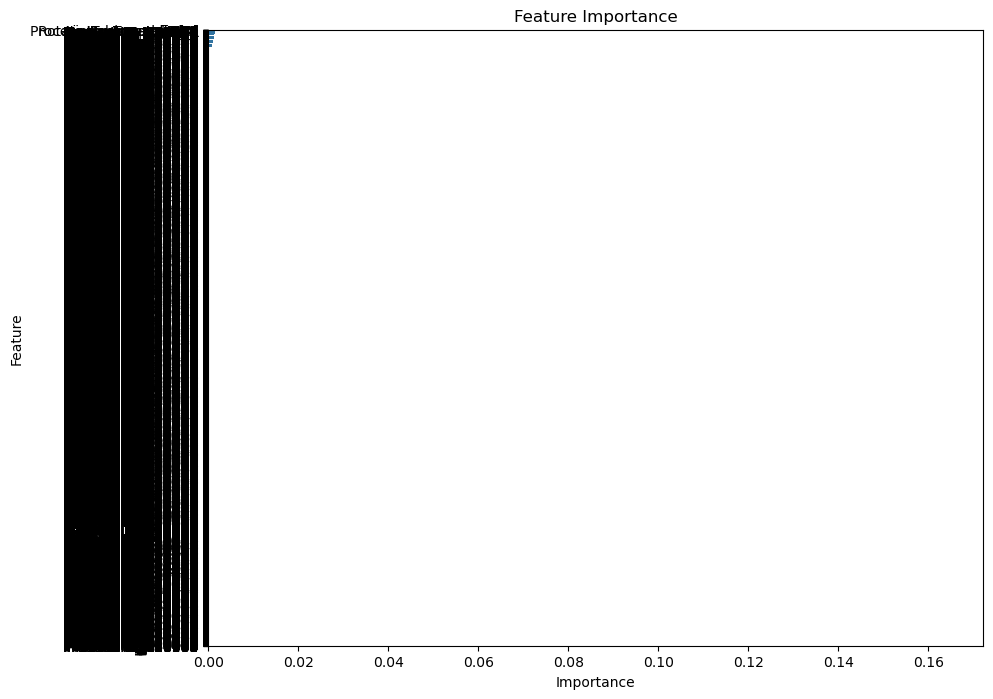

In [24]:
importances = model.feature_importances_
features = X.columns

fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=fi_df, x='Importance', y='Feature')
plt.title("Feature Importance")
save_fig("feature_importance.png")
plt.show()


# Conclusion

This analysis provided meaningful insights into machine failures and the operating conditions that influence them. Key operational features such as torque, rotational speed, and tool wear showed clear relationships with failure outcomes, helping to distinguish between normal and high-risk scenarios.

The machine-learning model trained in this project demonstrated strong predictive ability, showing that equipment failures can be anticipated effectively with the available data. This supports the broader value of predictive maintenance systems, which can greatly reduce unplanned downtime and improve operational efficiency.

## Next Steps

Future extensions of this project could include:

- More advanced hyperparameter tuning for model optimisation  
- Adding model interpretability techniques (e.g., SHAP values)  
- Deploying the model via Streamlit or a REST API  
- Testing the approach on real-world sensor data  

Overall, this project showcases core data-science skills: data cleaning, visualisation, feature engineering, modelling, and evaluation — all essential for practical predictive maintenance solutions.
